<a href="https://colab.research.google.com/github/Rohit5890/CodeTheGrid_GridPredict/blob/main/Race(Spain).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install kagglehub

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

import kagglehub

In [3]:
path = kagglehub.dataset_download("rohanrao/formula-1-world-championship-1950-2020")
print("Path to dataset files:", path)

100%|██████████| 6.28M/6.28M [00:00<00:00, 58.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/24


[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


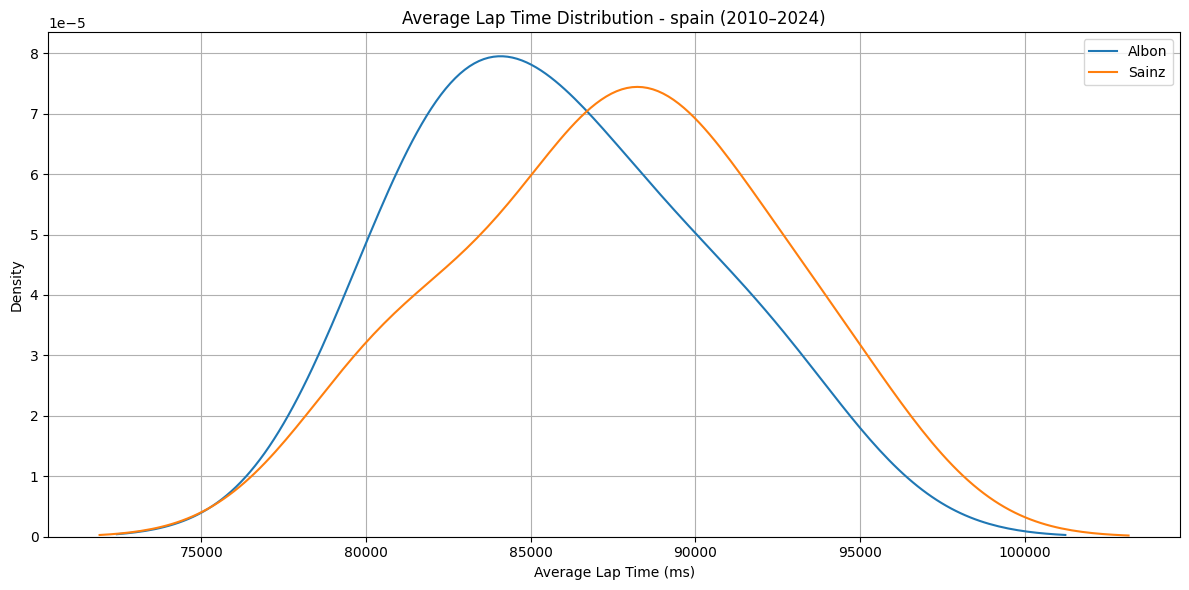

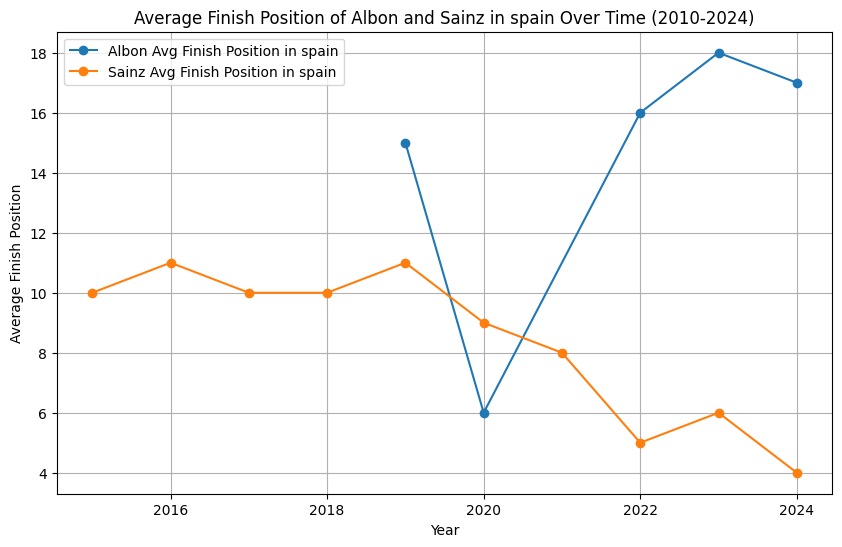

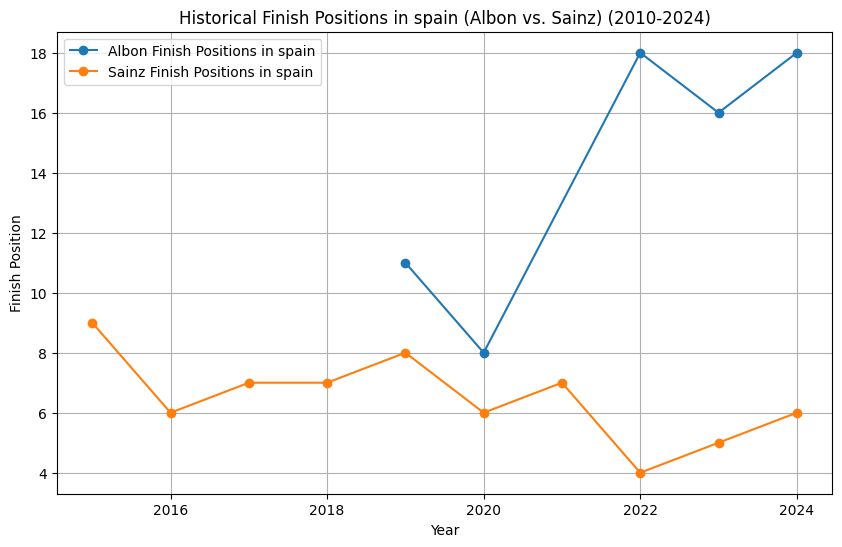

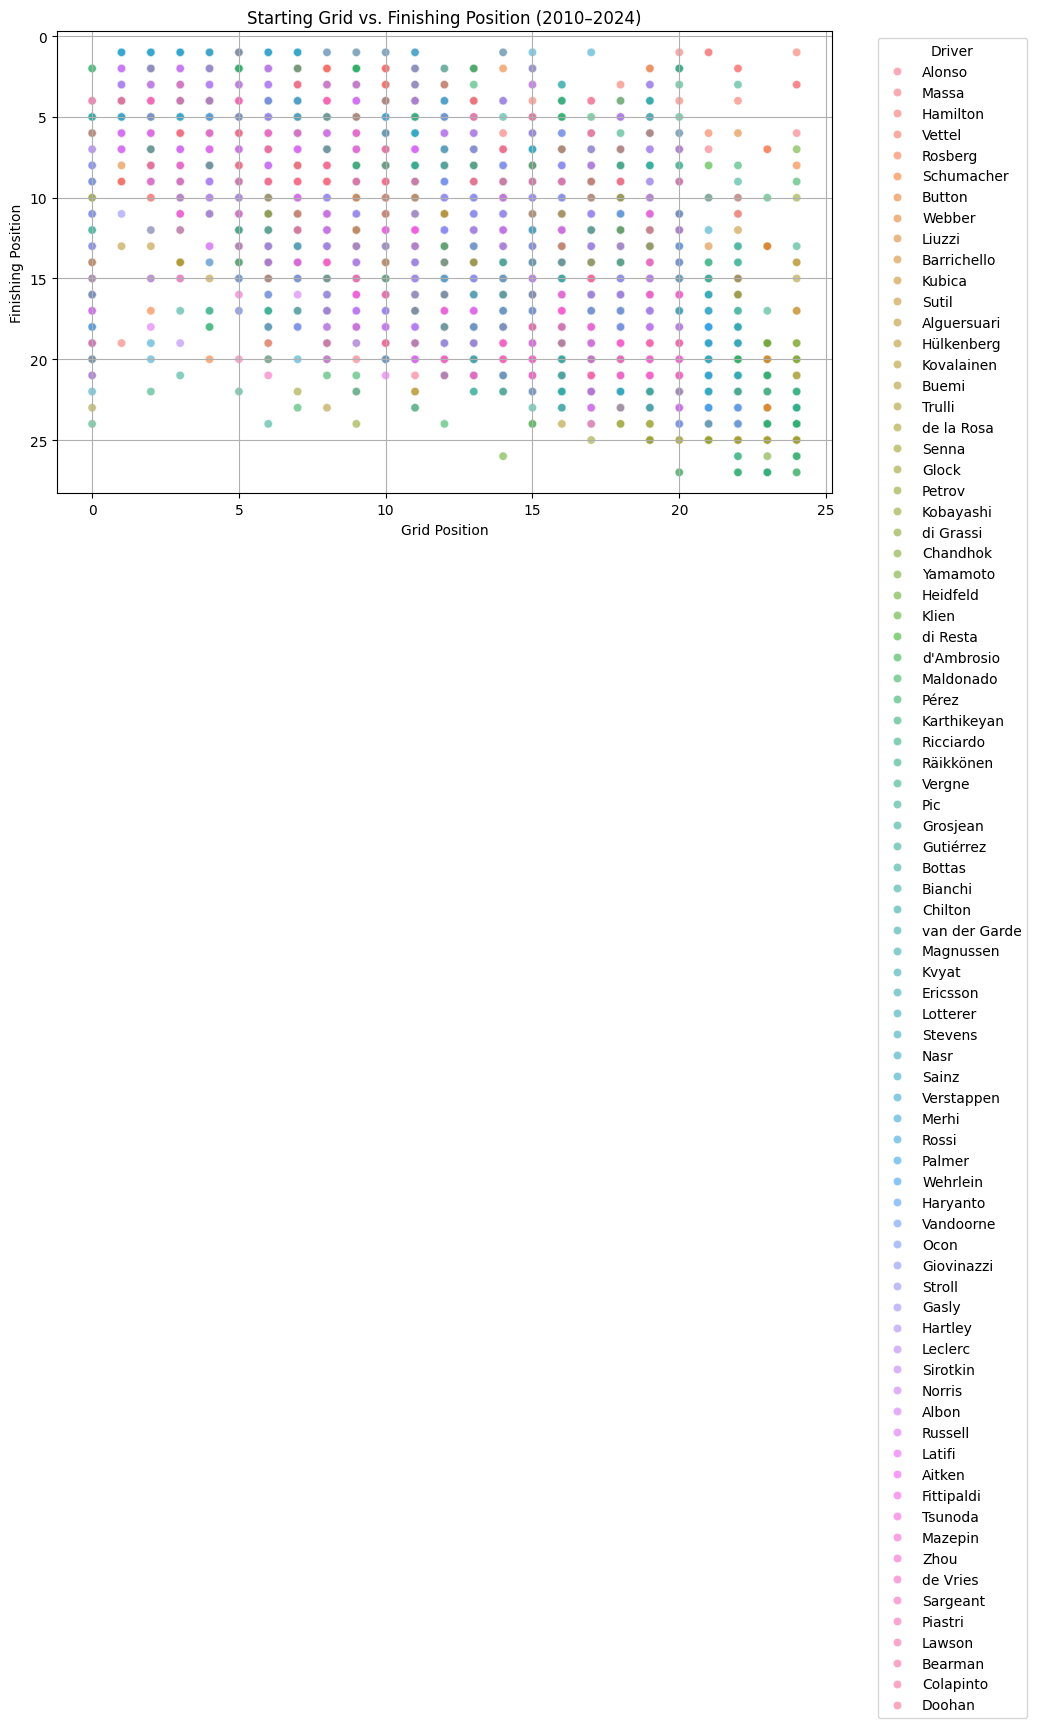

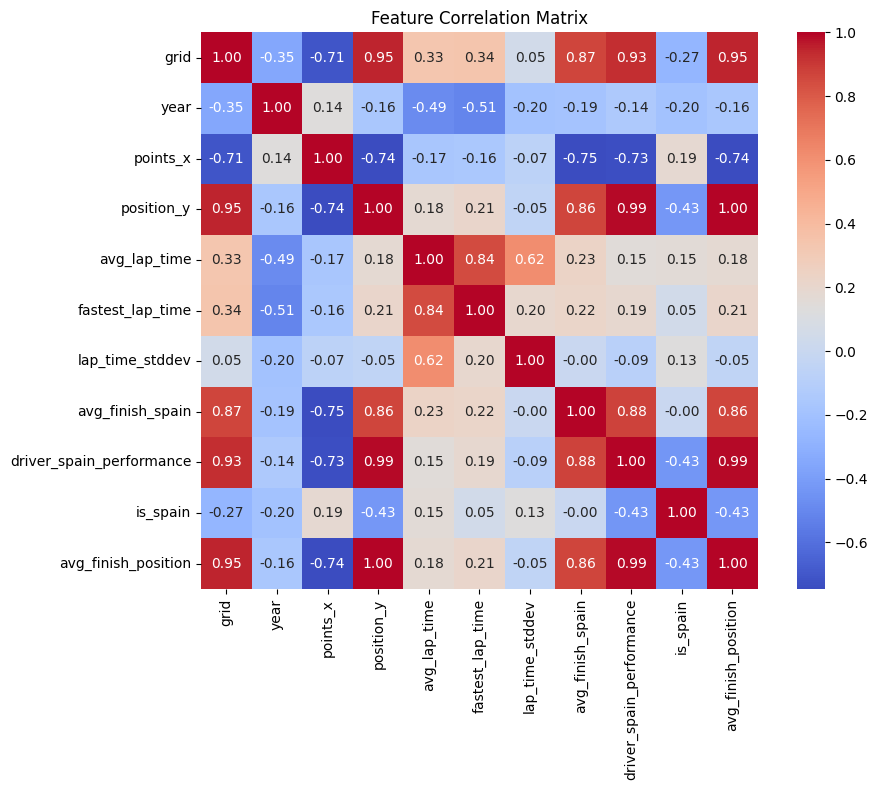

Random Forest MAE: 0.51
XGBoost MAE: 0.40
Using XGBoost model


In [79]:
def load_csv(name): return pd.read_csv(os.path.join(path, name))

results = load_csv("results.csv")
races = load_csv("races.csv")
drivers = load_csv("drivers.csv")
constructors = load_csv("constructors.csv")
constructor_results = load_csv("constructor_results.csv")
driver_standings = load_csv("driver_standings.csv")
lap_times = load_csv("lap_times.csv")

spain_race_ids = races[(races['name'].str.contains('Spanish', case=True)) & (races['year'] >=  2010)]['circuitId'].tolist()
print(spain_race_ids)
lap_features = lap_times.groupby(['raceId', 'driverId'])['milliseconds'].agg(
    avg_lap_time='mean',
    fastest_lap_time='min',
    lap_time_stddev='std'
).reset_index()

full_data = (
    results.merge(races, on='raceId', how='left')
           .merge(drivers, on='driverId', how='left')
           .merge(constructors, on='constructorId', how='left')
           .merge(constructor_results, on=['raceId', 'constructorId'], how='left')
           .merge(driver_standings, on=['raceId', 'driverId'], how='left')
           .merge(lap_features, on=['raceId', 'driverId'], how='left')
)

data = full_data[(full_data['year'] >= 2010) & (full_data['year'] <= 2024)].copy()

data.loc[:, 'grid'] = pd.to_numeric(data['grid'], errors='coerce').fillna(data['grid'].median())
data.loc[:, 'points_x'] = pd.to_numeric(data['points_x'], errors='coerce').fillna(0)
data.loc[:, 'position_y'] = pd.to_numeric(data['position_y'], errors='coerce').fillna(data['position_y'].median())
data.loc[:, 'avg_lap_time'] = data['avg_lap_time'].fillna(data['avg_lap_time'].mean())
data.loc[:, 'fastest_lap_time'] = data['fastest_lap_time'].fillna(data['fastest_lap_time'].mean())
data.loc[:, 'lap_time_stddev'] = data['lap_time_stddev'].fillna(data['lap_time_stddev'].mean())
data['position'] = pd.to_numeric(data['positionOrder'], errors='coerce')
data['is_spain'] = data['circuitId'].isin(spain_race_ids).astype(int)

target_drivers = ['Albon', 'Sainz']
data_filtered = data[data['surname'].isin(target_drivers) & data['is_spain'] == 1]

driver_stats = data_filtered.groupby('surname').agg(
    avg_finish_position=('position_y', 'mean'),
    podium_finishes=('position_y', lambda x: (x <= 3).sum()),
    total_points=('points', 'sum'),
    grid=('grid', 'mean'),
    year=('year', 'mean'),
    points_x=('points_x', 'sum'),
    position_y=('position_y', 'mean'),
    avg_lap_time=('avg_lap_time', 'mean'),
    fastest_lap_time=('fastest_lap_time', 'mean'),
    lap_time_stddev=('lap_time_stddev', 'mean'),
    avg_finish_spain=('position_y', 'mean')
).reset_index().set_index('surname')

driver_stats['driver_spain_performance'] = driver_stats['avg_finish_spain'].fillna(driver_stats['avg_finish_position'])
driver_stats['is_spain'] = 1


full_driver_stats = data.groupby('driverId').agg(
    avg_finish_position=('position_y', 'mean'),
    podium_finishes=('position_y', lambda x: (x <= 3).sum()),
    total_points=('points', 'sum'),
    grid=('grid', 'mean'),
    year=('year', 'mean'),
    points_x=('points_x', 'sum'),
    position_y=('position_y', 'mean'),
    avg_lap_time=('avg_lap_time', 'mean'),
    fastest_lap_time=('fastest_lap_time', 'mean'),
    lap_time_stddev=('lap_time_stddev', 'mean'),
    is_spain=('is_spain', 'max')
).reset_index()


full_driver_stats = full_driver_stats.merge(drivers[['driverId', 'surname']], on='driverId', how='left')

spain_avg = data[data['is_spain'] == 1].groupby('driverId')['position_y'].mean().reset_index(name='avg_finish_spain')
full_driver_stats = full_driver_stats.merge(spain_avg, on='driverId', how='left')
full_driver_stats['driver_spain_performance'] = full_driver_stats['avg_finish_spain'].fillna(full_driver_stats['avg_finish_position'])

features = [
    'grid', 'year', 'points_x', 'position_y', 'avg_lap_time',
    'fastest_lap_time', 'lap_time_stddev', 'avg_finish_spain',
    'driver_spain_performance', 'is_spain'
]

full_driver_stats[features] = full_driver_stats[features].fillna(full_driver_stats[features].mean())

X = full_driver_stats[features]
y = full_driver_stats['avg_finish_position']

plt.figure(figsize=(12, 6))

for driver in target_drivers:
    subset = data_filtered[data_filtered['surname'] == driver]
    sns.kdeplot(subset['avg_lap_time'], label=driver)

plt.title('Average Lap Time Distribution - spain (2010–2024)')
plt.xlabel('Average Lap Time (ms)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for driver in target_drivers:
    driver_data_spain = data_filtered[data_filtered['surname'] == driver]
    if not driver_data_spain.empty:
        avg_finish_by_year = driver_data_spain.groupby('year')['position_y'].mean()
        plt.plot(avg_finish_by_year.index, avg_finish_by_year.values, label=f'{driver} Avg Finish Position in spain', marker='o')
    else:
        print(f"No historical spain data for {driver} in the filtered years.")


plt.xlabel('Year')
plt.ylabel('Average Finish Position')
plt.title('Average Finish Position of Albon and Sainz in spain Over Time (2010-2024)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))

for driver in target_drivers:
    driver_data_spain = data_filtered[data_filtered['surname'] == driver]
    if not driver_data_spain.empty:
        plt.plot(driver_data_spain['year'], driver_data_spain['position'], label=f'{driver} Finish Positions in spain', marker='o')
    else:
         print(f"No historical spain finish position data for {driver} in the filtered years.")

plt.xlabel('Year')
plt.ylabel('Finish Position')
plt.title('Historical Finish Positions in spain (Albon vs. Sainz) (2010-2024)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='grid', y='position_y', hue='surname', alpha=0.6)
plt.title('Starting Grid vs. Finishing Position (2010–2024)')
plt.xlabel('Grid Position')
plt.ylabel('Finishing Position')
plt.gca().invert_yaxis()
plt.legend(title='Driver', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 8))
corr_matrix = full_driver_stats[features + ['avg_finish_position']].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


param_grid_rf = {
    'n_estimators': [100, 200, 250],
    'max_depth': [8,  20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)


param_grid_xgb = {
    'n_estimators': [100, 200, 250],
    'max_depth': [6, 12, 20],
    'learning_rate': [0.01, 0.005, 0.1]
}
grid_search_xgb = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid_xgb, cv=5, n_jobs=-1)
grid_search_xgb.fit(X_train_scaled, y_train)

rf_preds = grid_search_rf.predict(X_test)
xgb_preds = grid_search_xgb.predict(X_test_scaled)

rf_mae = mean_absolute_error(y_test, rf_preds)
xgb_mae = mean_absolute_error(y_test, xgb_preds)

print(f"Random Forest MAE: {rf_mae:.2f}")
print(f"XGBoost MAE: {xgb_mae:.2f}")

final_model = grid_search_rf.best_estimator_ if rf_mae < xgb_mae else grid_search_xgb.best_estimator_
print(f"Using {'Random Forest' if rf_mae < xgb_mae else 'XGBoost'} model")

In [81]:
upcoming_race_input = driver_stats[features]
upcoming_race_input = upcoming_race_input.fillna(full_driver_stats[features].mean())




if isinstance(final_model, xgb.XGBRegressor):
    upcoming_race_input_scaled = scaler.transform(upcoming_race_input)
    predictions = final_model.predict(upcoming_race_input_scaled)
else:
    predictions = final_model.predict(upcoming_race_input)

prediction_df = pd.DataFrame({
    'Driver': upcoming_race_input.index,
    'Predicted_Finish_Position': np.round(predictions).astype(int)
}).reset_index(drop=True)

print("Predicted Finish Positions for Spain Race:")
print(prediction_df)

f1_points = {1: 25, 2: 18, 3: 15, 4: 12, 5: 10, 6: 8, 7: 6, 8: 4, 9: 2, 10: 1}

williams_points = 0
for position in np.round(predictions).astype(int):
    williams_points += f1_points.get(position, 0)

print(f"\nPredicted Constructors’ points for Williams in Spain: {williams_points}")

Predicted Finish Positions for Spain Race:
  Driver  Predicted_Finish_Position
0  Albon                         14
1  Sainz                          6

Predicted Constructors’ points for Williams in Spain: 8
